# Cross-validation of models for Scala et al.

In [1]:
# Import packages
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib
import seaborn as sns
import sparseRRR
import matplotlib
import matplotlib.pyplot as plt
import importlib

import bottleneck_networks_tf2

import time
import pickle
import warnings

dtype = tf.float32

def sns_styleset():
    sns.set_style('ticks', {'axes.linewidth': .75, "xtick.major.size":4, "ytick.major.size":4})

# Loading data

In [4]:
scala = pickle.load(open('data/scala_2020/scala2020.pickle', 'rb'))
genes=scala['X']
ephys=scala['Y']
gene_names=scala['gene_names']
cell_types=scala['celltypes']
cell_id_to_cell_type=scala['map']
ephys_names=scala['ephys_features']
colors=scala['colors']

Let us find K-mean clusters to perform pre-training. One could also pre-train on celltype classification. This has actually improved performance even more but could be argued to be biasing the results too much. K-means allows for an unsupervised more general setting.

In [5]:
# You can cluster according to amounts of classes or amounts of celltypes. Change the argument of n_clusters accordingly.
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=20, random_state=17, n_init=1000).fit(ephys)

In [6]:
clusters = kmeans.labels_

In [7]:
amount_of_cells_in_clusters = {cluster_id: sum(clusters==cluster_id) for cluster_id in np.unique(clusters)}
for_every_cell_number_of_cells_of_their_cluster = np.array([amount_of_cells_in_clusters[cell] for cell in clusters])
ind_pre_training_clusters = for_every_cell_number_of_cells_of_their_cluster >= 10

In [8]:
c_n=[]
for i in np.unique(clusters):
    print('cluster ', i, 'represented by', sum(clusters==i), ' cells.')
    c_n.append(sum(clusters==i))
print('average # of cells per cluster: ', np.mean(np.array(c_n)))
print('std of # of cells per cluster: ', np.std(np.array(c_n)))

cluster  0 represented by 62  cells.
cluster  1 represented by 87  cells.
cluster  2 represented by 52  cells.
cluster  3 represented by 76  cells.
cluster  4 represented by 74  cells.
cluster  5 represented by 37  cells.
cluster  6 represented by 54  cells.
cluster  7 represented by 61  cells.
cluster  8 represented by 30  cells.
cluster  9 represented by 74  cells.
cluster  10 represented by 40  cells.
cluster  11 represented by 85  cells.
cluster  12 represented by 116  cells.
cluster  13 represented by 45  cells.
cluster  14 represented by 76  cells.
cluster  15 represented by 74  cells.
cluster  16 represented by 42  cells.
cluster  17 represented by 50  cells.
cluster  18 represented by 58  cells.
cluster  19 represented by 20  cells.
average # of cells per cluster:  60.65
std of # of cells per cluster:  22.100395924055295


# Keras initialisations

In [9]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics
from tensorflow.keras.losses import CategoricalCrossentropy

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

In [11]:
tf.compat.v1.disable_eager_execution()

In [12]:
# You should assume you get two TensorFlow variables as input
y_actual = tf.compat.v1.placeholder(dtype = tf.float32)
y_predicted = tf.compat.v1.placeholder(dtype = tf.float32)
def r2_score(y_truth, y_pred):
    residual = tf.add(y_truth, -y_pred, name='residual')
    return 1-tf.reduce_sum(input_tensor=tf.square(residual)) / tf.reduce_sum(input_tensor=tf.square(y_truth))
r2_score_result = r2_score(y_actual, y_predicted)

In [13]:
class ElasticNet(tf.keras.regularizers.Regularizer): 
    def __init__(self, l1=1e-8, l2=1.0): 
        self.l1 = l1
        self.l2 = l2

    def __call__(self, x): 
        return self.l2*tf.math.reduce_sum(input_tensor=tf.math.square(x)) + \
                             self.l1*tf.reduce_sum(input_tensor=tf.norm(tensor=x, ord = 2, axis = 1))

    def get_config(self): 
        return {'l1': float(self.l1), 'l2': float(self.l2)}

## Cross validation to various training strategies

Group lasso + ridge penalty straight regression (no pre-training) model.

In [13]:
from bottleneck_networks_tf2 import StraightRegression

In [14]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-1])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
prune=True
patience=epochs

r2_straight_regr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_ap = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_ap_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))
r2_straight_regr_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))

t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

nodes_list=[512,128,64,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            BN_StraightRegression = StraightRegression(l1=l1, l2=l2, lr=lr, act=act, \
                                                       input_dim=input_dim, output_dim=output_dim, nodes_list=nodes_list)
            r2_train, r2_test, \
                r2_ap_train, r2_ap_test, \
                train_hist, test_hist = BN_StraightRegression.train(x_train=x_train, y_train=y_train, \
                                                                                   x_test=x_test, y_test=y_test, \
                                                                                   epochs=epochs, bs=bs, patience=patience, \
                                                                                   cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                                   prune=prune, geneNames=gene_names, \
                                                                                   verbose=0)
            r2_straight_regr[cvfold, j, i] = r2_test
            r2_straight_regr_tr[cvfold, j, i] = r2_train
            r2_straight_regr_ap[cvfold, j, i] = r2_ap_test
            r2_straight_regr_ap_tr[cvfold, j, i] = r2_ap_train
            r2_straight_regr_hist[cvfold, j, i] = test_hist
            r2_straight_regr_hist_tr[cvfold, j, i] = train_hist
            #print('Test R^2 score (straight regression, no pre-tr): ', r2_straight_regr[cvfold, j, i])
            #print('Test R^2 score after pruning (straight regression, no pre-tr): ', r2_straight_regr_ap[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[INFO] training network...


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


The 25 genes that make it:  ['Col24a1' 'Kcnip2' 'Pde1a' '6720468P15Rik' 'Enpp2' 'Gm49948' 'Ndnf'
 'Elmo1' 'Mybpc1' 'Atp1a3' 'Reln' 'Tafa1' 'Ndn' 'Htr3a' 'Fxyd6' 'Thsd7a'
 'Galnt14' 'Cplx1' 'Erbb4' 'Tac2' 'Lamp5' 'Sst' 'Gad1' 'Vip' 'Pvalb']
[INFO] training network...
Train R^2 before pruning:  0.4926719665527344
Test R^2 after pruning:  0.46250760555267334
Train R^2 after pruning:  0.4627925753593445
Test R^2 after pruning:  0.45104753971099854

CVFOLD:  1
[INFO] training network...
The 25 genes that make it:  ['Reln' 'Kcnab3' 'Cdc42se2' 'Slc6a1' 'Gm43670' 'Elmo1' 'Galnt14' 'Plch2'
 'Cck' 'Htr3a' 'Ndn' 'Gm49948' 'Enpp2' 'Tafa1' 'Kcnc2' 'Erbb4' 'Cplx1'
 'Fxyd6' 'Tac2' 'Atp1a3' 'Sst' 'Lamp5' 'Gad1' 'Pvalb' 'Vip']
[INFO] training network...
Train R^2 before pruning:  0.4821015000343323
Test R^2 after pruning:  0.44340699911117554
Train R^2 after pruning:  0.46663379669189453
Test R^2 after pruning:  0.4234775900840759

CVFOLD:  2
[INFO] training network...
The 25 genes that make it:  ['Unc

In [15]:
with open('KerasSavedModels/scala_2020_tf2/Bottleneck_r2_straight_regr_lasso_no_bottleneck.pickle', 'wb') as f:
    pickle.dump([r2_straight_regr, r2_straight_regr_tr, \
                 r2_straight_regr_ap, r2_straight_regr_ap_tr, \
                 r2_straight_regr_hist, r2_straight_regr_hist_tr], f)

Group lasso + ridge penalty classification pre-training model.

In [14]:
from bottleneck_networks_tf2 import ClassificationPreTrain

In [15]:
# Immediately for different penalties, but we'll be only interested in the 1e-1 penalty (for now), i.e. see extensions later
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-4, 1e-2, 1e-1, 1])

act = 'elu'
folds = 3
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs


t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]
clusters_ = clusters[ind]
ind_pre_train = ind_pre_training_clusters[ind]

CE_loss = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
CE_loss_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
pre_tr_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))
pre_tr_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))

nodes_list=[512,128,64,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    clusters_train = np.copy(clusters_[indtrain])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    clusters_test = np.copy(clusters_[indtest])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean

    # In our training set we now look for a 'pretraining' training and test data set that we can use
    # for pretraing a classification network, i.e. picking the best model will be dones with a seperate val set in our
    # training set for regression.

    x_train_pre_tr = x_train[ind_pre_train[indtrain], :]
    clusters_train_pre_tr = clusters_train[ind_pre_train[indtrain]]
    
    pre_train_size = 0.6
    train_cnt = round(x_train_pre_tr.shape[0]*pre_train_size)
    x_train_pre_tr_ = x_train_pre_tr[:train_cnt, :]
    x_test_pre_tr_ = x_train_pre_tr[train_cnt:, :]
    clusters_train_pre_tr_ = clusters_train_pre_tr[:train_cnt]
    clusters_test_pre_tr_ = clusters_train_pre_tr[train_cnt:]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)


            input_dim = x_train.shape[1]
            output_dim = to_categorical(clusters_train_pre_tr).shape[1]
            BN_Classification = ClassificationPreTrain(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, \
                                                       output_dim=output_dim, nodes_list=nodes_list)
            CE_train, CE_test, train_hist, test_hist = BN_Classification.train(x_train=x_train_pre_tr_, \
                                                                               cluster_train=clusters_train_pre_tr_, \
                                                                               x_test=x_test_pre_tr_, \
                                                                               cluster_test=clusters_test_pre_tr_, \
                                                                               epochs=epochs, bs=bs, patience=patience, \
                                                                               cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                               verbose=0)
            CE_loss[cvfold, j, i] = CE_test
            CE_loss_tr[cvfold, j, i] = CE_train
            pre_tr_hist[cvfold, j, i] = test_hist
            pre_tr_hist_tr[cvfold, j, i] = train_hist
            #print('Test CE loss (pre-trainin): ', CE_loss[cvfold, j, i])
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
[INFO] training network...


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


[INFO] training network...
[INFO] training network...
[INFO] training network...

CVFOLD:  1
[INFO] training network...
[INFO] training network...
[INFO] training network...
[INFO] training network...

CVFOLD:  2
[INFO] training network...
[INFO] training network...
[INFO] training network...
[INFO] training network...
Time: 0.0h  1m 32s


In [16]:
with open('KerasSavedModels/scala_2020_tf2/Bottleneck_pre_tr_lasso_no_bottleneck.pickle', 'wb') as f:
    pickle.dump([CE_loss, CE_loss_tr, pre_tr_hist, pre_tr_hist_tr], f)

Group lasso + ridge penalty pre-train and regression model.

In [19]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-1])

act = 'elu'
folds = 3
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
pre_trained_weights=True
prune=True

r2_pretr_straight_regr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_ap = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_ap_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))
r2_pretr_straight_regr_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))

t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

nodes_list=[512,128,64,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            
            pre_trained_weights_h5 = 'KerasSavedModels/Classification_last_weights_{}_{}_{}.h5'.format(cvfold, 2, i)
            
            BN_PreTrStraightRegression = StraightRegression(l1=l1, l2=l2, lr=lr, act=act, \
                                            input_dim=input_dim, output_dim=output_dim, \
                                            pre_trained_weights=pre_trained_weights, \
                                            pre_trained_weights_h5=pre_trained_weights_h5, nodes_list=nodes_list)
            r2_train, r2_test, \
                r2_train_ap, r2_test_ap, \
                train_hist, test_hist = BN_PreTrStraightRegression.train(x_train=x_train, y_train=y_train, \
                                                                                   x_test=x_test, y_test=y_test, \
                                                                                   epochs=epochs, bs=bs, patience=patience, \
                                                                                   cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                                   prune=prune, geneNames=gene_names, \
                                                                                   verbose=0)
            r2_pretr_straight_regr[cvfold, j, i] = r2_test
            r2_pretr_straight_regr_tr[cvfold, j, i] = r2_train
            r2_pretr_straight_regr_ap[cvfold, j, i] = r2_test_ap
            r2_pretr_straight_regr_ap_tr[cvfold, j, i] = r2_train_ap            
            r2_pretr_straight_regr_hist[cvfold, j, i] = test_hist
            r2_pretr_straight_regr_hist_tr[cvfold, j, i] = train_hist
            #print('Test R^2 score (regression, after pre-tr): ', r2_pretr_straight_regr[cvfold, j, i])
            #print('Test R^2 score (regression, after pre-tr), after pruning: ', r2_pretr_straight_regr_ap[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
[INFO] training network...
The 25 genes that make it:  ['Unc13c' 'Arhgap32' 'Tafa1' 'Grm7' 'Th' 'Idh3a' 'Gm49948' 'Spon1' 'Elfn1'
 'Enpp2' 'Gabra1' 'Ndn' 'Sema3c' 'Mas1' 'Fxyd6' 'Cplx1' 'Atp1a3' 'Kcnc2'
 'Thsd7a' 'Erbb4' 'Lamp5' 'Gad1' 'Tac2' 'Vip' 'Pvalb']
[INFO] training network...
Train R^2 before pruning:  0.521702915430069
Test R^2 after pruning:  0.42676854133605957
Train R^2 after pruning:  0.47844940423965454
Test R^2 after pruning:  0.4096892476081848

CVFOLD:  1
[INFO] training network...
The 25 genes that make it:  ['Ncald' 'Nos1' 'Bdnf' 'Cck' 'Vsir' 'Kcnc2' 'Ndst3' 'Cplx1' 'Rtn3' 'Tafa1'
 'Gas7' 'Fxyd6' 'Cdh13' 'Erbb4' 'Mybpc1' 'Galnt14' 'Tac2' 'Thsd7a' 'Pamr1'
 'Lamp5' 'Htr3a' 'Gad1' 'Vip' 'Sst' 'Pvalb']
[INFO] training network...
Train R^2 before pruning:  0.5548890233039856
Test R^2 after pruning:  0.42968833446502686
Train R^2 after pruning:  0.48152124881744385
Test R^2 after pruning:  0.4006425738334656

CVFOLD:  2
[INFO] training network...
The 25 genes t

In [20]:
with open('KerasSavedModels/scala_2020_tf2/Bottleneck_r2_pre_tr_and_straight_regr_lasso_no_bottleneck.pickle', 'wb') as f:
    pickle.dump([r2_pretr_straight_regr, r2_pretr_straight_regr_tr, \
                 r2_pretr_straight_regr_ap, r2_pretr_straight_regr_ap_tr, \
                 r2_pretr_straight_regr_hist, r2_pretr_straight_regr_hist_tr], f)

Group lasso + ridge penalty pre-train + freeze the first 2 layers + unfreeze model.

In [17]:
importlib.reload(bottleneck_networks_tf2)

<module 'bottleneck_networks_tf2' from '/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/sBNN/bottleneck_networks_tf2.py'>

In [18]:
from bottleneck_networks_tf2 import FreezeUnfreeze

In [19]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-4, 1e-2, 1e-1, 1])

act = 'elu'
folds = 3
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
pre_trained_weights=True
unfreeze = [False, False, True, True, True, True] # last 4 layers can be trained only first
prune=True

r2_before_unfreezing = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_before_unfreezing_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_ap = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_ap_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_freeze_unfreeze_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))
r2_freeze_unfreeze_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))

t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

nodes_list=[512,128,64,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            
            pre_trained_weights_h5 = 'KerasSavedModels/Classification_last_weights_{}_{}_{}.h5'.format(cvfold, j, i)
            input_dim = x_train.shape[1]
            output_dim = y_train.shape[1]
            BN_PreTrFreezeUnfreeze = FreezeUnfreeze(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, output_dim=output_dim, \
                                                       unfreeze = unfreeze, \
                                                       pre_trained_weights=pre_trained_weights, \
                                                       pre_trained_weights_h5=pre_trained_weights_h5, nodes_list=nodes_list)
            r2_before_unfreezing_train, r2_before_unfreezing_test, \
                r2_after_unfreezing_train, r2_after_unfreezing_test, \
                r2_after_unfreezing_train_ap, r2_after_unfreezing_test_ap, \
                train_hist, test_hist = BN_PreTrFreezeUnfreeze.train(x_train=x_train, y_train=y_train, \
                                                                    x_test=x_test, y_test=y_test, \
                                                                    epochs=epochs, bs=bs, patience=patience, \
                                                                    cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                    prune=prune, geneNames=gene_names, \
                                                                    verbose=0,
                                                                    report_individual_ephys_feature_test_R2=True)
            r2_before_unfreezing[cvfold, j, i] = r2_before_unfreezing_test
            r2_before_unfreezing_tr[cvfold, j, i] = r2_before_unfreezing_train
            r2_after_unfreezing[cvfold, j, i] = r2_after_unfreezing_test
            r2_after_unfreezing_tr[cvfold, j, i] = r2_after_unfreezing_train
            r2_after_unfreezing_ap[cvfold, j, i] = r2_after_unfreezing_test_ap
            r2_after_unfreezing_ap_tr[cvfold, j, i] = r2_after_unfreezing_train_ap
            r2_freeze_unfreeze_hist[cvfold, j, i] = test_hist
            r2_freeze_unfreeze_hist_tr[cvfold, j, i] = train_hist
            #print('Test R^2 score (before unfreezing): ', r2_before_unfreezing[cvfold, j, i])
            #print('Test R^2 score (after unfreezing): ', r2_after_unfreezing[cvfold, j, i])
            #print('Test R^2 score (after unfreezing and after pruning): ', r2_after_unfreezing_ap[cvfold, j, i])
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[INFO] training network...
[INFO] training network...


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


The 25 genes that make it:  ['Kcnc2' 'Cadps2' 'Lancl3' 'Ap1s2' 'Cmtr2' 'Cacna1e' 'Fstl5' 'Pvalb'
 'Ccr5' 'Baiap2' 'Slc2a3' 'Lingo2' 'Rora' 'Tmem44' 'Trpm2' 'Kctd21' 'Egr2'
 'Opcml' 'Ndst3' 'Rab11a' 'Cep83os' 'Dmrt2' 'Pamr1' 'Nbr1' 'Col24a1']
[INFO] training network...
Train R^2 before unfreezing:  0.6303770244121552
Test R^2 before unfreezing:  0.3773595094680786
Train R^2 after unfreezing:  0.7510461658239365
Test R^2 after unfreezing:  0.3784949779510498
Train R^2 after unfreezing and pruning:  0.4021405577659607
Test R^2 after unfreezing and pruning:  0.32771188020706177
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Coa5' 'Epha4' 'Sstr2' 'Neat1' 'Col6a1' 'Col6a2' 'Gad2' 'Scube1'
 'Gm11549' 'Cd34' 'Ak5' 'Enpp2' 'Ccn1' 'Pamr1' 'Nrp1' 'Crym' 'Blnk'
 'Fezf2' 'Gm48745' 'Neurod6' 'Scara3' 'Mas1' 'Tmem63a' 'Tafa1' 'Adcyap1']
[INFO] training network...
Train R^2 before unfreezing:  0.6387826502323151
Test R^2 before unfreezing:  0.40611493587493896
Trai

In [20]:
with open('KerasSavedModels/scala_2020_tf2/Bottleneck_r2_pre_tr_and_freeze_unfreeze_lasso_no_bottleneck.pickle', 'wb') as f:
    pickle.dump([r2_before_unfreezing, r2_before_unfreezing_tr, \
                 r2_after_unfreezing, r2_after_unfreezing_tr, \
                 r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
                 r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr], f)

In [40]:
individual_ephys_test_R2_scores=np.zeros((folds,Y.shape[1]))
for i in range(folds):
    individual_ephys_test_R2_scores[i,:]=np.load('KerasSavedModels/individual_ephys_feature_test_R2_{}_2_0_nb.npz'\
                                                             .format(i))['R2']
individual_R2_scores={}
individual_R2_scores_std={}
for i in range(Y.shape[1]):
    individual_R2_scores.update(
        {ephys_names[i]:np.mean(individual_ephys_test_R2_scores, axis=0)[i]}
                               )
    individual_R2_scores_std.update(
        {ephys_names[i]:np.std(individual_ephys_test_R2_scores, axis=0)[i]}
                               )
R2_full=np.mean(r2_freeze_unfreeze_hist[:,2,0,-1],axis=0)
print('R^2 score on all: ', R2_full)
print('\nindividual contributions: ')
individual_R2_scores

R^2 score on all:  0.39728141725063326

individual contributions: 


{'AP amp': 0.5233319103717804,
 'AP amp adapt': 0.3731975754102071,
 'AP amp CV': -0.009308358033498129,
 'AP thresh': 0.08034402132034302,
 'AP width': 0.731165329615275,
 'AHP': 0.6177818973859152,
 'AI': 0.326288362344106,
 'ISI CV': 0.43613457679748535,
 'R_input': 0.5323546628157297,
 'Max AP num': 0.7207182745138804,
 'Tau': 0.3486028512318929,
 'Rebound': 0.36925144990285236,
 'V_rest': 0.1597218910853068,
 'Rheobase': 0.36861759424209595,
 'Sag': 0.26075098911921185,
 'UDR': 0.7739744285742441}

In [41]:
print("individual contributions \w their std's")
individual_R2_scores_std

individual contributions \w their std's


{'AP amp': 0.010493994707849516,
 'AP amp adapt': 0.01755518679301579,
 'AP amp CV': 0.018152087572414276,
 'AP thresh': 0.025826706277906897,
 'AP width': 0.015773169923619206,
 'AHP': 0.02460160237648746,
 'AI': 0.02995057295004485,
 'ISI CV': 0.01557241312315267,
 'R_input': 0.04981063064791512,
 'Max AP num': 0.012143026042797633,
 'Tau': 0.007508997361585351,
 'Rebound': 0.06851535327601407,
 'V_rest': 0.02833875593662878,
 'Rheobase': 0.05678037203519015,
 'Sag': 0.036822647212034876,
 'UDR': 0.011077186217225142}

In [42]:
with open('KerasSavedModels/scala_2020_tf2/ind_feature_scores_nb.pickle', 'wb') as f:
    pickle.dump([individual_R2_scores, individual_R2_scores_std], f)

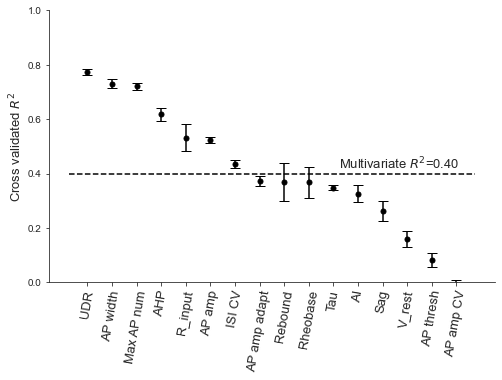

In [43]:
order=np.argsort(np.array([individual_R2_scores[key] for key in individual_R2_scores]))[::-1]
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.errorbar(np.array([key for key in individual_R2_scores])[order],
            np.array([individual_R2_scores[key] for key in individual_R2_scores])[order],
            np.array([individual_R2_scores_std[key] for key in individual_R2_scores_std])[order],
            marker='.', color='k', markersize=10, capsize=5, linestyle='none')
ax.hlines(R2_full,
          xmin=ax.get_xlim()[0],
          xmax=ax.get_xlim()[1],
          linestyle='dashed')
ax.set_ylim(ymin=0,ymax=1)
ax.annotate(r'Multivariate $R^2$={0:.2f}'.format(R2_full),
           (ax.get_xlim()[0]+1.3*(ax.get_xlim()[1]-ax.get_xlim()[0])/2, R2_full+0.02),
            fontsize=13)
plt.xticks(rotation='80', fontsize=13)
ax.set_ylabel(r'Cross validated $R^2$', fontsize=13)
sns.despine()

Let us now analyse and visualise the differences.

In [21]:
lambdas = np.arange(.1,2,.1)
alphas = np.array([1])

In [22]:
with open('KerasSavedModels/scala_2020_tf2/sRRR_vs_Bottleneck_rank2_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2 = pickle.load(f)

In [23]:
with open('KerasSavedModels/scala_2020_tf2/sRRR_vs_Bottleneck_rank16_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank16, r2_sRRR_relaxed_rank16, r2_sRRR_rank16_tr, r2_sRRR_relaxed_rank16_tr, \
                nonzero_rank16, corrs_rank16, corrs_relaxed_rank16 = pickle.load(f)

In [24]:
with open('KerasSavedModels/scala_2020_tf2/Bottleneck_pre_tr_lasso.pickle', 'rb') as f:
    CE_loss, CE_loss_tr, pre_tr_hist, pre_tr_hist_tr = pickle.load(f)

In [25]:
with open('KerasSavedModels/scala_2020_tf2/Bottleneck_pre_tr_lasso_no_bottleneck.pickle', 'rb') as f:
    CE_loss_nb, CE_loss_tr_nb, pre_tr_hist_nb, pre_tr_hist_tr_nb = pickle.load(f)

In [26]:
with open('KerasSavedModels/scala_2020_tf2/Bottleneck_r2_straight_regr_lasso.pickle', 'rb') as f:
    r2_straight_regr, r2_straight_regr_tr, \
    r2_straight_regr_ap, r2_straight_regr_ap_tr, \
    r2_straight_regr_hist, r2_straight_regr_hist_tr = pickle.load(f)

In [27]:
with open('KerasSavedModels/scala_2020_tf2/Bottleneck_r2_straight_regr_lasso_no_bottleneck.pickle', 'rb') as f:
    r2_straight_regr_nb, r2_straight_regr_tr_nb, \
    r2_straight_regr_ap_nb, r2_straight_regr_ap_tr_nb, \
    r2_straight_regr_hist_nb, r2_straight_regr_hist_tr_nb = pickle.load(f)

In [28]:
with open('KerasSavedModels/scala_2020_tf2/Bottleneck_r2_pre_tr_and_straight_regr_lasso.pickle', 'rb') as f:
    r2_pretr_straight_regr, r2_pretr_straight_regr_tr, \
    r2_pretr_straight_regr_ap, r2_pretr_straight_regr_ap_tr, \
    r2_pretr_straight_regr_hist, r2_pretr_straight_regr_hist_tr = pickle.load(f)

In [29]:
with open('KerasSavedModels/scala_2020_tf2/Bottleneck_r2_pre_tr_and_straight_regr_lasso_no_bottleneck.pickle', 'rb') as f:
    r2_pretr_straight_regr_nb, r2_pretr_straight_regr_tr_nb, \
    r2_pretr_straight_regr_ap_nb, r2_pretr_straight_regr_ap_tr_nb, \
    r2_pretr_straight_regr_hist_nb, r2_pretr_straight_regr_hist_tr_nb = pickle.load(f)

In [30]:
with open('KerasSavedModels/scala_2020_tf2/Bottleneck_r2_pre_tr_and_freeze_unfreeze_lasso.pickle', 'rb') as f:
    r2_before_unfreezing, r2_before_unfreezing_tr, \
    r2_after_unfreezing, r2_after_unfreezing_tr, \
    r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
    r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr = pickle.load(f)

In [31]:
with open('KerasSavedModels/scala_2020_tf2/Bottleneck_r2_pre_tr_and_freeze_unfreeze_lasso_no_bottleneck.pickle', 'rb') as f:
    r2_before_unfreezing_nb, r2_before_unfreezing_tr_nb, \
    r2_after_unfreezing_nb, r2_after_unfreezing_tr_nb, \
    r2_after_unfreezing_ap_nb, r2_after_unfreezing_ap_tr_nb, \
    r2_freeze_unfreeze_hist_nb, r2_freeze_unfreeze_hist_tr_nb = pickle.load(f)

In [32]:
# Select closest to 25 genes value
# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

In [33]:
print(r_rank16_r[np.isclose(n_rank16, 25, atol=3)][0], '+/-',
      np.nanstd(r2_sRRR_relaxed_rank16, axis=0)[0, :][np.isclose(n_rank16, 25, atol=3)][0])

0.39811512463141036 +/- 0.016844028073453247


In [34]:
print(r_rank2_r[np.isclose(n_rank2, 25, atol=3)][0], '+/-',
      np.nanstd(r2_sRRR_relaxed_rank2, axis=0)[0, :][np.isclose(n_rank2, 25, atol=3)][0])

0.35036089702192025 +/- 0.019618703438733235


In [35]:
print(np.mean(r2_freeze_unfreeze_hist,axis=0)[2,0,-1], '+/-', np.std(r2_freeze_unfreeze_hist,axis=0)[2,0,-1])

0.39728141725063326 +/- 0.02221465147618321


In [36]:
print(np.mean(r2_freeze_unfreeze_hist_nb,axis=0)[2,0,-1], '+/-', np.std(r2_freeze_unfreeze_hist_nb,axis=0)[2,0,-1])

0.4085913896560669 +/- 0.011105088393733078


In [37]:
print(np.mean(r2_straight_regr_hist,axis=0)[0,0,-1], '+/-', np.std(r2_straight_regr_hist,axis=0)[0,0,-1])

0.3740154504776001 +/- 0.021394069010219213


In [38]:
print(np.mean(r2_straight_regr_hist_nb,axis=0)[0,0,-1], '+/-', np.std(r2_straight_regr_hist_nb,axis=0)[0,0,-1])

0.412414887547493 +/- 0.02264313753349095


In [68]:
ax3

(<Figure size 648x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd9fb0da850>)

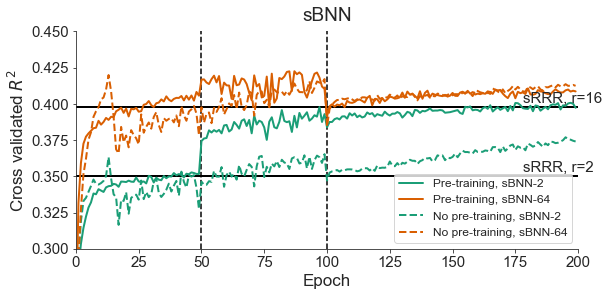

In [74]:
# All together in one plot
linewidth = 2
sns_styleset()

epochs_used=200
fig, ax3 = plt.subplots(1,1,figsize=(9,4))
ax3.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist, axis=(0))[2,0,:], \
        c='#1b9e77', linewidth=linewidth, label='Pre-training, sBNN-2')
ax3.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_nb, axis=(0))[2,0,:], \
        c='#d95f02', linewidth=linewidth, label='Pre-training, sBNN-64')
ax3.plot(range(epochs_used), np.mean(r2_straight_regr_hist, axis=(0))[0,0,:], \
        '--', c='#1b9e77', linewidth=linewidth, label='No pre-training, sBNN-2')
ax3.plot(range(epochs_used), np.mean(r2_straight_regr_hist_nb, axis=(0))[0,0,:], \
        '--', c='#d95f02', linewidth=linewidth, label='No pre-training, sBNN-64')
ax3.hlines(r_rank16_r[np.isclose(n_rank16, 25, atol=3)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax3.hlines(r_rank2_r[np.isclose(n_rank2, 25, atol=3)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax3.set_ylim([0.3,0.45])
ax3.set_xlim([0,200])
ax3.set_xticks(np.arange(0, 225, 25))
ax3.annotate('sRRR, r=16', (178, r_rank16_r[np.isclose(n_rank16, 25, atol=3)]+0.003), fontsize=15)
ax3.annotate('sRRR, r=2', (178, r_rank2_r[np.isclose(n_rank2, 25, atol=3)]+0.003), fontsize=15)
ax3.set_title('sBNN', fontsize = 19, y=1.02)
ax3.set_xlabel('Epoch', fontsize = 17)
ax3.set_ylabel(r'Cross validated $R^2$', fontsize = 17)
ax3.tick_params(axis='both', which='major', labelsize=15)
ax3.tick_params(axis='both', which='minor', labelsize=15)
ax3.legend(loc='lower right', fontsize=12)
ax3.vlines(x=50, ymin=ax3.get_ylim()[0], ymax=ax3.get_ylim()[1], linestyles='dashed')
ax3.vlines(x=100, ymin=ax3.get_ylim()[0], ymax=ax3.get_ylim()[1], linestyles='dashed')

# plt.text(-0.25, 1.04, 'a', transform = ax1.transAxes, fontsize=25, fontweight='bold')
# plt.text(-0.11, 1.04, 'b', transform = ax2.transAxes, fontsize=25, fontweight='bold')
# plt.text(-0.13, 1.04, 'c', transform = ax3.transAxes, fontsize=25, fontweight='bold')
sns.despine()

plt.savefig('figures/Lasso_training_curves_w_no_bottleneck.pdf', bbox_inches='tight',
    pad_inches=0.1)
plt.savefig('figures/Lasso_training_curves_w_no_bottleneck.png', bbox_inches='tight',
    pad_inches=0.1)

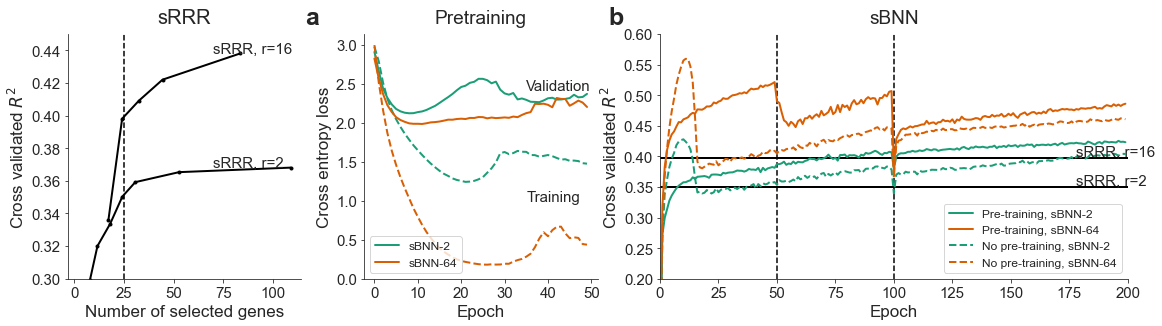

In [75]:
# All together in one plot
linewidth = 2
sns_styleset()

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

# All together in one plot for the paper
fig = plt.figure(figsize=(19, 4.5))
widths = [1, 1, 2]
heights = [1]
spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths,
                          height_ratios=heights)

ax1 = fig.add_subplot(spec[0, 0])
ax1.plot(n_2, cr_2, '.-', c = np.array([0, 0, 0])/256, linewidth=2)
ax1.plot(n_16[1:], cr_16[1:], '.-', c = np.array([0, 0, 0]) / 256, linewidth=2)
ax1.set_ylim([0.3,0.45])
ax1.set_xlabel('Number of selected genes', fontsize = 17)
ax1.set_ylabel(r'Cross validated $R^2$', fontsize = 17)
ax1.set_title('sRRR', fontsize = 20, y=1.02)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='minor', labelsize=15)
ax1.vlines(x=25, ymin=ax1.get_ylim()[0], ymax=ax1.get_ylim()[1], linestyles='dashed')
ax1.annotate('sRRR, r=16', (70, np.max(cr_16)+0.0003), fontsize=15)
ax1.annotate('sRRR, r=2', (70, np.max(cr_2)+0.0003), fontsize=15)


ax2 = fig.add_subplot(spec[0, 1])
ax2.plot(range(50), np.mean(pre_tr_hist, axis=(0, 2))[2, :], \
         c = '#1b9e77', linewidth=linewidth, label='sBNN-2')
ax2.plot(range(50), np.mean(pre_tr_hist_tr, axis=(0, 2))[2, :], \
         '--', c = '#1b9e77', linewidth=linewidth)
ax2.plot(range(50), np.mean(pre_tr_hist_nb, axis=(0, 2))[2, :], \
         c = '#d95f02', linewidth=linewidth, label='sBNN-64')
ax2.plot(range(50), np.mean(pre_tr_hist_tr_nb, axis=(0, 2))[2, :], \
         '--', c = '#d95f02', linewidth=linewidth)
ax2.set_title('Pretraining', fontsize = 19, y=1.02)
ax2.set_xlabel('Epoch', fontsize = 17)
ax2.set_ylabel('Cross entropy loss', fontsize = 17)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='minor', labelsize=15)
ax2.set_ylim([0, ax2.get_ylim()[1]])
ax2.annotate('Training', (35, 1), fontsize=15)
ax2.annotate('Validation', (35, 2.42), fontsize=15)
ax2.set_xticks(np.arange(0, 60, 10))
ax2.legend(loc='lower left', fontsize=12)

epochs_used=200
ax3 = fig.add_subplot(spec[0, 2])
ax3.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_tr, axis=(0))[2,0,:], \
        c='#1b9e77', linewidth=linewidth, label='Pre-training, sBNN-2')
ax3.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_tr_nb, axis=(0))[2,0,:], \
        c='#d95f02', linewidth=linewidth, label='Pre-training, sBNN-64')
ax3.plot(range(epochs_used), np.mean(r2_straight_regr_hist_tr, axis=(0))[0,0,:], \
        '--', c='#1b9e77', linewidth=linewidth, label='No pre-training, sBNN-2')
ax3.plot(range(epochs_used), np.mean(r2_straight_regr_hist_tr_nb, axis=(0))[0,0,:], \
        '--', c='#d95f02', linewidth=linewidth, label='No pre-training, sBNN-64')
ax3.hlines(r_rank16_r[np.isclose(n_rank16, 25, atol=3)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax3.hlines(r_rank2_r[np.isclose(n_rank2, 25, atol=3)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax3.set_ylim([0.2,0.6])
ax3.set_xlim([0,200])
ax3.set_xticks(np.arange(0, 225, 25))
ax3.annotate('sRRR, r=16', (178, r_rank16_r[np.isclose(n_rank16, 25, atol=3)]+0.003), fontsize=15)
ax3.annotate('sRRR, r=2', (178, r_rank2_r[np.isclose(n_rank2, 25, atol=3)]+0.003), fontsize=15)
ax3.set_title('sBNN', fontsize = 19, y=1.02)
ax3.set_xlabel('Epoch', fontsize = 17)
ax3.set_ylabel(r'Cross validated $R^2$', fontsize = 17)
ax3.tick_params(axis='both', which='major', labelsize=15)
ax3.tick_params(axis='both', which='minor', labelsize=15)
ax3.legend(loc='lower right', fontsize=12)
ax3.vlines(x=50, ymin=ax3.get_ylim()[0], ymax=ax3.get_ylim()[1], linestyles='dashed')
ax3.vlines(x=100, ymin=ax3.get_ylim()[0], ymax=ax3.get_ylim()[1], linestyles='dashed')

plt.text(-0.25, 1.04, 'a', transform = ax2.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.11, 1.04, 'b', transform = ax3.transAxes, fontsize=25, fontweight='bold')
sns.despine()

plt.savefig('figures/Lasso_training_curves_w_no_bottleneck_tr.pdf', bbox_inches='tight',
    pad_inches=0.1)
plt.savefig('figures/Lasso_training_curves_w_no_bottleneck_tr.png', bbox_inches='tight',
    pad_inches=0.1)